In [35]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
from io import BytesIO

In [36]:
link_list = []
def scrape_index_page(page_number=None):
    if(page_number):
        index_page_number = page_number + 1
    else:
        index_page_number = 1
    index_page_url = f"https://www.skinnytaste.com/recipe-index/?_paged={index_page_number}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
    }
    response = requests.get(index_page_url, headers=headers)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        container = soup.find('div', {'class': 'ast-row'})
        articles = container.find_all('article')
        for article in articles:
            link = article.find('a')
            if link and 'href' in link.attrs:
                # Add link to list
                link_list.append(link['href'])

        if(index_page_number <= 50):
            scrape_index_page(page_number=index_page_number)
        
        return link_list
    else:
        raise ValueError(f"Failed to retrieve index page with index: {index_page_number}")
    
def scrape_recipe_pages(links):
    data = []
    for link in links:
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
        }
        response = requests.get(link, headers=headers)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            container = soup.find('div', {'class': 'wprm-recipe-container'})
            if container is not None:
                recipe_keys_elem = soup.find('ul', {'class': 'cat-icons'}).find_all(class_=lambda c: c and 'cat-icon__' in c)
                recipe_keys = [icon.get('title') for icon in recipe_keys_elem if icon.has_attr('title')]

                name_elem = container.find('h2', {'class': 'wprm-recipe-name'})
                name = name_elem.text.strip() if name_elem else ''

                calories_elem = container.find('span', {'class': 'wprm-recipe-calories'})
                calories = calories_elem.text.strip() if calories_elem else 0

                summary_elem = container.find('div', {'class': 'wprm-recipe-summary'}).find('span')
                summary = summary_elem.text.strip() if summary_elem else ''

                points_elem = container.find('span', {'class': 'wprm-recipe-custom-field-key-ww_personal_points'})
                points = points_elem.text.strip() if points_elem else 0
                
                img_elem = container.find('div', {'class': 'wprm-recipe-image-container'}).find('img')
                if 'data-lazy-src' in img_elem.attrs:
                    img = img_elem['data-lazy-src']
                else:
                    img = img_elem['src']
                
                data.append({
                    'Name': name,
                    'Calories': float(calories),
                    'Summary': summary,
                    'Points': int(points),
                    'Image': img,
                    'Air Fryer Recipe': 'Air Fryer Recipes' in recipe_keys,
                    'Freezer Meal': 'Freezer Meals' in recipe_keys,
                    'Dairy Free Recipe': 'Dairy Free Recipes' in recipe_keys,
                    'Gluten Free': 'Gluten Free' in recipe_keys,
                    'High Protein Recipe': 'High Protein Recipes' in recipe_keys,
                    'High-Fiber Recipe': 'High-Fiber Recipes' in recipe_keys,
                    'Kid Friendly': 'Kid Friendly' in recipe_keys,
                    'Low Carb': 'Low Carb' in recipe_keys,
                    'Meal Prep Recipe': 'Meal Prep Recipes' in recipe_keys,
                    'Pressure Cooker Recipe': 'Pressure Cooker Recipes' in recipe_keys,
                    'Slow Cooker Recipe': 'Slow Cooker Recipes' in recipe_keys,
                    'Under 30 Minute': 'Under 30 Minutes' in recipe_keys,
                    'Vegetarian Meal': 'Vegetarian Meals' in recipe_keys,
                    'Whole30 Recipe': 'Whole30 Recipes' in recipe_keys,
                })
            else:
                print(f"Failed parsing HTML found for link: {link} \n skipping...")
        else:
            raise ValueError(f"Failed to retrieve recipe page: {link}")
        
    return data


In [37]:
# Visualizations
def calories_barchart(df):
    # Sort dataframe by 'Calories' column
    df_sorted = df.sort_values(by='Calories', ascending=False)

    # Normalize
    norm = plt.Normalize(df_sorted['Calories'].min(), df_sorted['Calories'].max())

    # Colors
    colors = plt.cm.Blues(norm(df_sorted['Calories']))

    plt.figure(figsize=(12, 8))
    bars = plt.bar(df_sorted['Name'], df_sorted['Calories'], color=colors)

    plt.xticks([])
    plt.ylabel('Calories')
    plt.title('Recipes Sorted By Calories with Blue Color Scaling')

    plt.show()

def keys_piechart(df):
    # Specify the columns you want to include in the pie chart
    selected_columns = [
        'Air Fryer Recipe', 
        'Freezer Meal', 
        'Dairy Free Recipe', 
        'Gluten Free', 
        'High Protein Recipe', 
        'High-Fiber Recipe', 
        'Kid Friendly', 
        'Low Carb', 
        'Meal Prep Recipe', 
        'Pressure Cooker Recipe', 
        'Slow Cooker Recipe', 
        'Under 30 Minute', 
        'Vegetarian Meal', 
        'Whole30 Recipe'
    ]

    # Filter the DataFrame to keep only the selected columns
    df_selected = df[selected_columns]

    # Count the number of True values for each selected category
    category_counts = df_selected.sum()

    # Create the pie chart
    plt.figure(figsize=(16, 12))
    plt.pie(category_counts, labels=category_counts.index, autopct=lambda pct: percent_and_number(pct, category_counts), startangle=140, colors=plt.cm.tab20.colors)
    plt.title('Proportion of Recipes by Category')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

def points_histogram(df):
    counts, bins = np.histogram(df['Points'], bins=range(0, df['Points'].max() + 2))

    # Colors
    normed_counts = counts / counts.max()  # Normalize counts to [0, 1]
    colors = plt.cm.Blues(normed_counts * 0.7)  # Decrease contrast (multiply by 0.7)

    plt.figure(figsize=(10, 6))

    for count, color, bin_left in zip(counts, colors, bins[:-1]):
        plt.bar(bin_left, count, width=1, color=color, edgecolor='black', alpha=0.8)  # Set alpha for bars

    plt.title('Histogram of Points')
    plt.xlabel('Points')
    plt.ylabel('Frequency')
    plt.xticks(bins)
    plt.grid(axis='y', linestyle='--', alpha=0.3)  # More transparent y-lines
    plt.show()
    
#Helpers
def percent_and_number(pct, allvals):
    absolute = int(pct / 100. * sum(allvals))
    return f"{absolute} ({pct:.1f}%)"


['https://www.skinnytaste.com/freezer-breakfast-burritos/', 'https://www.skinnytaste.com/crustless-pumpkin-pie/', 'https://www.skinnytaste.com/red-curry-salmon/', 'https://www.skinnytaste.com/free-7-day-healthy-meal-plan-sept-23-29/', 'https://www.skinnytaste.com/apple-butter-recipe/', 'https://www.skinnytaste.com/roasted-delicata-squash/', 'https://www.skinnytaste.com/applesauce-nut-bread/', 'https://www.skinnytaste.com/autumn-salad-with-pears-and-gorgonzola/', 'https://www.skinnytaste.com/sesame-chicken/', 'https://www.skinnytaste.com/bacon-in-the-oven/', 'https://www.skinnytaste.com/skinny-pumpkin-spiced-latte/', 'https://www.skinnytaste.com/homemade-hamburger-helper/', 'https://www.skinnytaste.com/fried-brown-rice/', 'https://www.skinnytaste.com/easy-sheet-pan-dinners/', 'https://www.skinnytaste.com/asian-grilled-chicken-33-pts_3510/', 'https://www.skinnytaste.com/sweet-potato-salad/', 'https://www.skinnytaste.com/ratatouille/', 'https://www.skinnytaste.com/best-air-fryer-chicken-r

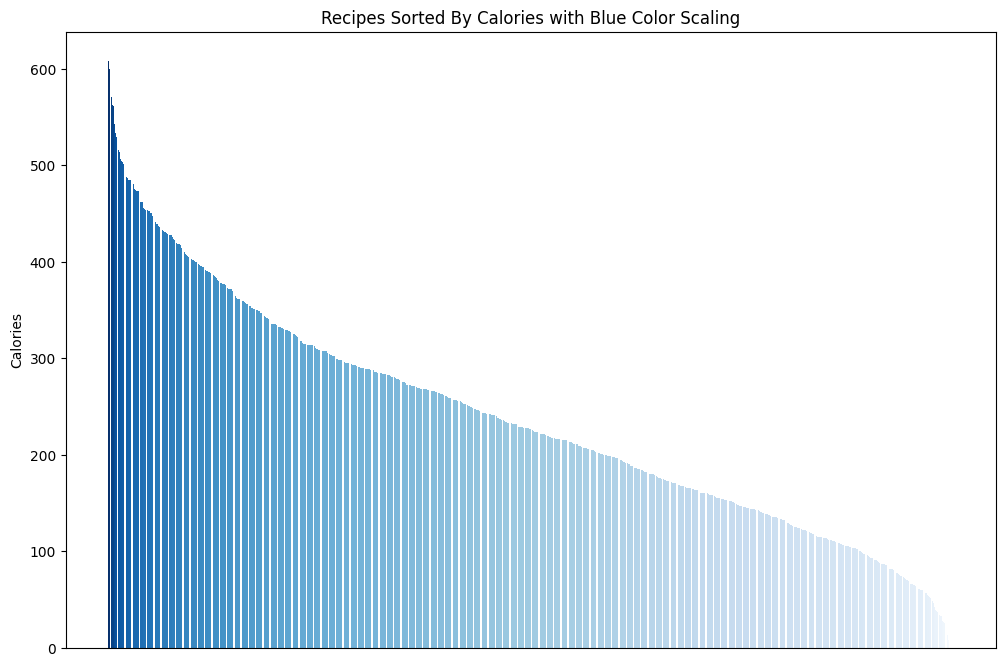

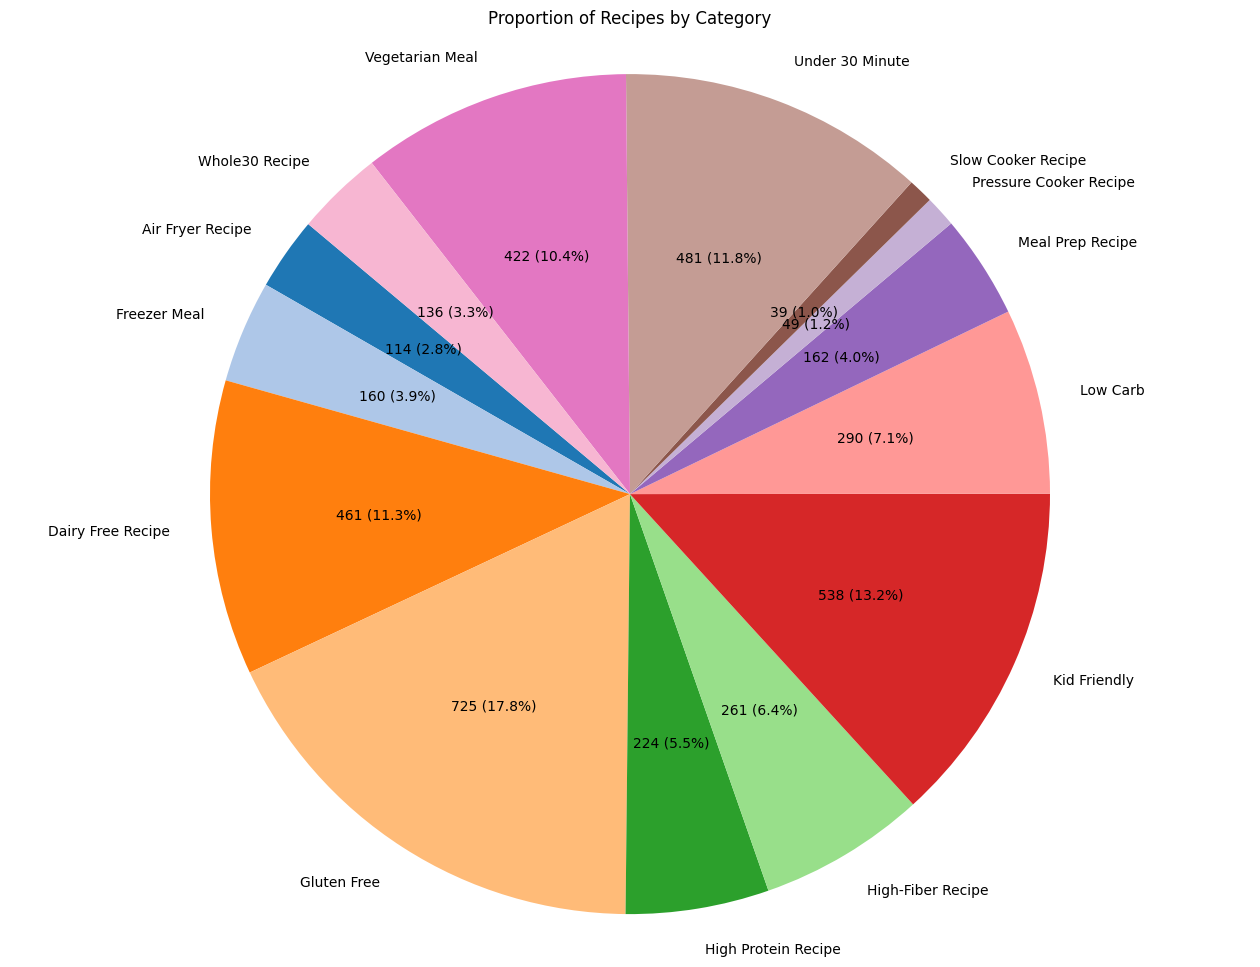

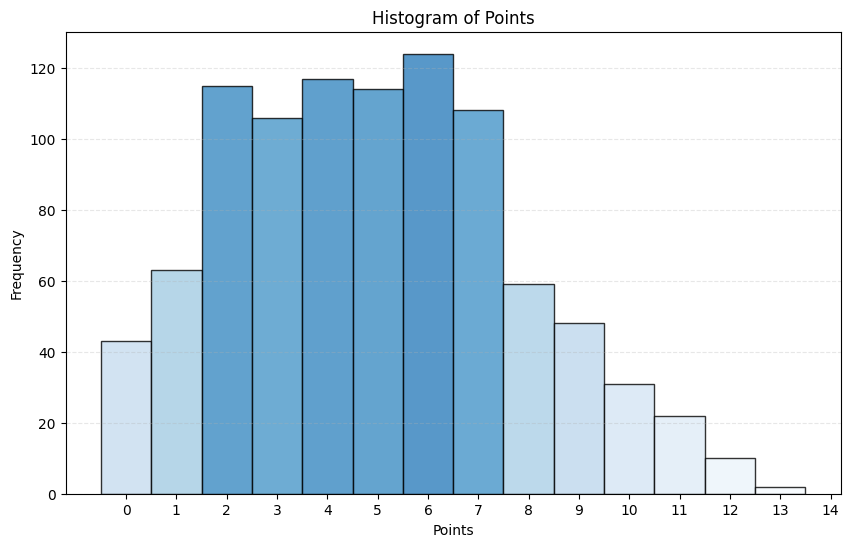

In [38]:
# Scrape data
links = scrape_index_page()
data = scrape_recipe_pages(links)

# Convert to dataframe
df = pd.DataFrame(data)
df.drop_duplicates()
df_cleaned = df[(df['Calories'] != 0) & (df['Points'] != 0)]

# Visualize data
calories_barchart(df)
keys_piechart(df)
points_histogram(df)

In [39]:
#User input
def user_option():
    result = input("Select filtering technique:     1. Calorie range    2. Weightwatchers points    3.Both")
    try:
        option = int(result)
    except ValueError:
        print("Please enter a valid number (1, 2 or 3)")

    from_val2 = None
    to_val2 = None
    column2 = None

    if option == 1:
        from_val, to_val = calories_input()
        column = 'Calories'
    elif option == 2:
        from_val, to_val = points_input()
        column = 'Points'
    elif option == 3:
        from_val, to_val = calories_input()
        from_val2, to_val2 = points_input()
        column, column2 = 'Calories','Points'
    else:
        print("Not an option! \n Choose between: 1, 2 or 3")

    return display_result(from_val=from_val, to_val=to_val, column=column, from_val2=from_val2, to_val2=to_val2, column2=column2)

def calories_input():
    from_calories = input("Enter range of calories (FROM): ")
    to_calories = input("Enter range of calories (TO): ")
    fr, to = verify_input(from_calories, to_calories, 'calories')
    return fr, to

def points_input():
    from_point = input("Enter range of points (FROM): ")
    to_point = input("Enter range of points (TO): ")
    fr, to = verify_input(from_point, to_point, 'points')
    return fr, to

#Show results
def display_result(from_val, to_val, column, from_val2 = None, to_val2 = None, column2 = None):
    if column2 == None:
        filtered_df = df[(df[column] >= from_val) & (df[column] <= to_val)]
    else:
        filtered_df = df[(df[column] >= from_val) & (df[column] <= to_val)]
        filtered_df = filtered_df[(df[column2] >= from_val2) & (df[column2] <= to_val2)]
    
    return filtered_df.reset_index(drop=True)
    
#Helpers
def verify_input(input1, input2, caller):
    # Convert the input to a float
    try:
        from_val, to_val = float(input1), float(input2)
    except ValueError:
        print("Please enter a valid number")

    if(from_val > to_val):
        print(f"{from_val} is smaller than {to_val} \n Try again ...")
        if caller == 'points':
            points_input()
        else:
            calories_input()
    
    return from_val, to_val

1:
 Name: Pumpkin Spice Latte Recipe
 Calories: 115.0
 WeightWatcher points: 7
 Embrace the cozy fall vibes with this homemade Pumpkin Spice Latte recipe! You can make your own at home for a fraction of the cost.
 Keys: Dairy Free Recipe, Gluten Free, Vegetarian Meal, 


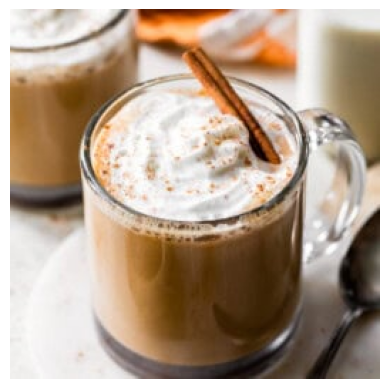

2:
 Name: Ratatouille Recipe
 Calories: 115.0
 WeightWatcher points: 2
 Ratatouille is the perfect summer side dish for your favorite roasted chicken, grilled meats, or fish! It adds a burst of color and flavor to every meal.
 Keys: Dairy Free Recipe, Gluten Free, Meal Prep Recipe, Vegetarian Meal, 


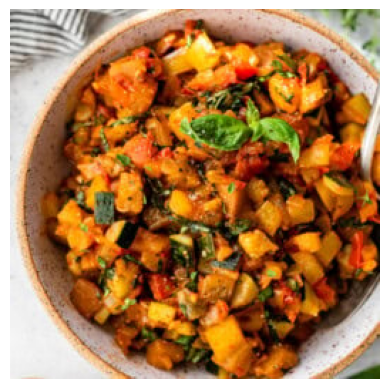

3:
 Name: Coconut Popsicles
 Calories: 106.0
 WeightWatcher points: 5
 These homemade coconut popsicles are rich, creamy, and super simple to make! They’re the perfect summertime refresher.
 Keys: Gluten Free, Kid Friendly, 


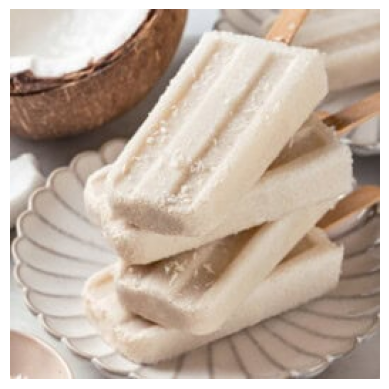

4:
 Name: Grilled Eggplant with Feta
 Calories: 106.0
 WeightWatcher points: 3
 If you need an easy side dish this summer, this grilled eggplant with feta cheese is great with anything you’re grilling.
 Keys: Gluten Free, Low Carb, Under 30 Minute, Vegetarian Meal, 


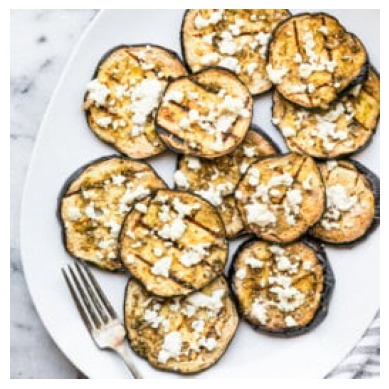

5:
 Name: Blueberry Zucchini Bread
 Calories: 111.0
 WeightWatcher points: 4
 This moist and delicious Blueberry Zucchini Bread is low-fat, lightly sweetened, and loaded with summer zucchini and blueberries. Perfect for breakfast or as a snack!
 Keys: Freezer Meal, Kid Friendly, Vegetarian Meal, 


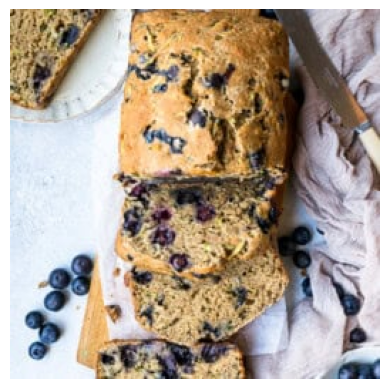

6:
 Name: Eton Mess Recipe
 Calories: 109.0
 WeightWatcher points: 6
 Eton Mess is a classic British dessert made with berries (I used strawberries), whipped cream, and crushed vanilla meringue cookies. You can assemble it in one large bowl or layer it in individual glasses.
 Keys: Kid Friendly, Under 30 Minute, 


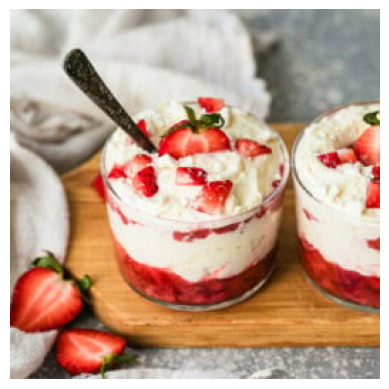

7:
 Name: Baked Honey-Mustard Ham
 Calories: 106.0
 WeightWatcher points: 3
 This easy, 4-ingredient Honey-Mustard Ham recipe is made with honey, Dijon mustard, and a touch of brown sugar on a baked spiral ham.
 Keys: Dairy Free Recipe, Gluten Free, Low Carb, 


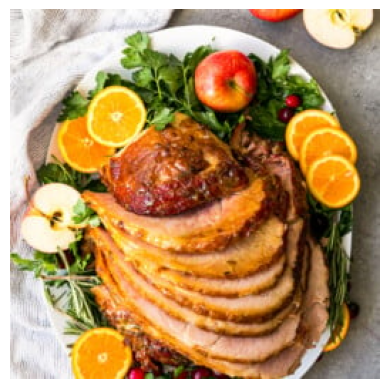

8:
 Name: Bloody Mary Deviled Eggs Recipe
 Calories: 113.0
 WeightWatcher points: 1
 Bloody Mary Deviled Eggs with bacon, cornichons, Old Bay seasoning and celery are a fun twist on classic deviled eggs.
 Keys: Dairy Free Recipe, Gluten Free, High Protein Recipe, Low Carb, 


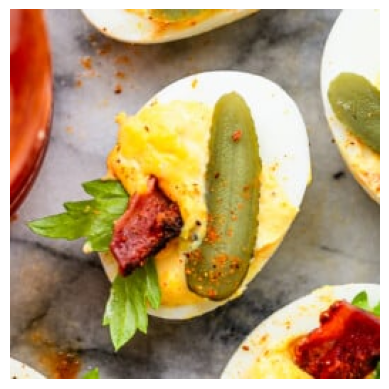

9:
 Name: Crock Pot Pasta Sauce with Sausage
 Calories: 115.0
 WeightWatcher points: 4
 This easy, 5-ingredient Crock Pot Pasta Sauce made with chicken or turkey sausage is perfect for busy weeknights!
 Keys: Dairy Free Recipe, Gluten Free, Slow Cooker Recipe, 


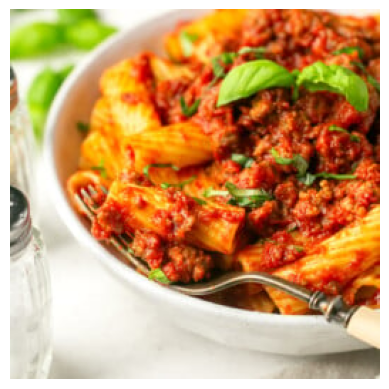

10:
 Name: Snowman Chocolate Bark
 Calories: 118.0
 WeightWatcher points: 5
 Snowman Chocolate Bark is a fun, sweet treat, perfect for the holidays, Christmas, or winter. Mini marshmallows, chocolate, pretzel sticks, and sprinkles create adorable snowmen, excellent for gift-giving.
 Keys: High-Fiber Recipe, Kid Friendly, Vegetarian Meal, 


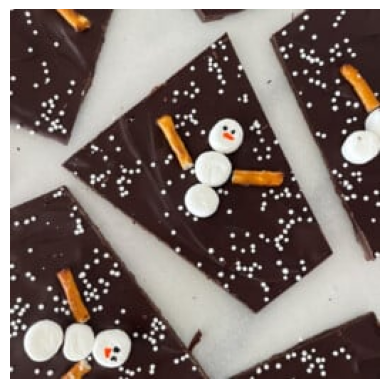

In [43]:
# USERS - USE THIS CELL! #
result = user_option()

for index, row in result.iterrows():
    if index >= 10:
        break
    print(f"{index+1}:\n Name: {row.Name}\n Calories: {row.Calories}\n WeightWatcher points: {row.Points}\n {row.Summary}\n Keys: {'Air Fryer Recipe, ' if row['Air Fryer Recipe'] else ''}{'Freezer Meal, ' if row['Freezer Meal'] else ''}{'Dairy Free Recipe, ' if row['Dairy Free Recipe'] else ''}{'Gluten Free, ' if row['Gluten Free'] else ''}{'High Protein Recipe, ' if row['High Protein Recipe'] else ''}{'High-Fiber Recipe, ' if row['High-Fiber Recipe'] else ''}{'Kid Friendly, ' if row['Kid Friendly'] else ''}{'Low Carb, ' if row['Low Carb'] else ''}{'Meal Prep Recipe, ' if row['Meal Prep Recipe'] else ''}{'Pressure Cooker Recipe, ' if row['Pressure Cooker Recipe'] else ''}{'Slow Cooker Recipe, ' if row['Slow Cooker Recipe'] else ''}{'Under 30 Minute, ' if row['Under 30 Minute'] else ''}{'Vegetarian Meal, ' if row['Vegetarian Meal'] else ''}{'Whole30 Recipe, ' if row['Whole30 Recipe'] else ''}")
    response = requests.get(row['Image'])
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.axis('off')
    plt.show()